#Network Traffic Prediction Using LSTM
This tutorial shows how to create a relatively simple LSTM by importing data, preprossing, model training, and  hyperparameter tuning

Network traffic is the amount of data moving across a computer network at any time. Network traffic forecasting could help optimize network monitoring, threat detection, and resource management.

## About the Dataset
Having across a computer network at any time. : Network traffic is the amount of data moving across a computer network at any time. Network traffic forecasting could help optimize network monitoring, threat detection, and resource management
* The dataset covers 10 workstation IPs from 0 to 9 and contains the columns: date, count of connections(flows), local IP number, and remote asn.

* However we will only be using samples from flows on IPN 9

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import GRU
import sympy
import numpy as np
import collections

import IPython
import IPython.display

from sklearn import preprocessing

from IPython.display import clear_output
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


import time
from tensorflow.keras import datasets, layers, models

# Reading in Data
This section is all about reading in the dataset and transforming it so that it can preprocessed.

In [ ]:
df = pd.read_csv('/cs448b_ipasn.csv')
df = df[df['l_ipn'] == 9]
df

,date,l_ipn,r_asn,f
183,2006-07-01,9,102,43
184,2006-07-01,9,209,6
185,2006-07-01,9,559,1
186,2006-07-01,9,701,8
187,2006-07-01,9,1239,17
...,...,...,...,...
20589,2006-09-29,9,8070,2
20590,2006-09-29,9,8075,2
20800,2006-09-30,9,2152,1
20801,2006-09-30,9,8070,1


Changing the date column in the data to pandas date time for visualizing data over time.

In [ ]:

df['date']= pd.to_datetime(df['date'])
df = df.groupby(['date','l_ipn'],as_index=False).sum()
df['yday'] = df['date'].dt.dayofyear
df['wday'] = df['date'].dt.dayofweek

Establishing that flows is are target variable by singling the column out.

In [ ]:
df_2d = df[['f']].values

This plot shows the flow count over time to visualize the shape of the data and outliers to see what methods are necessary for an accurate LSTM model

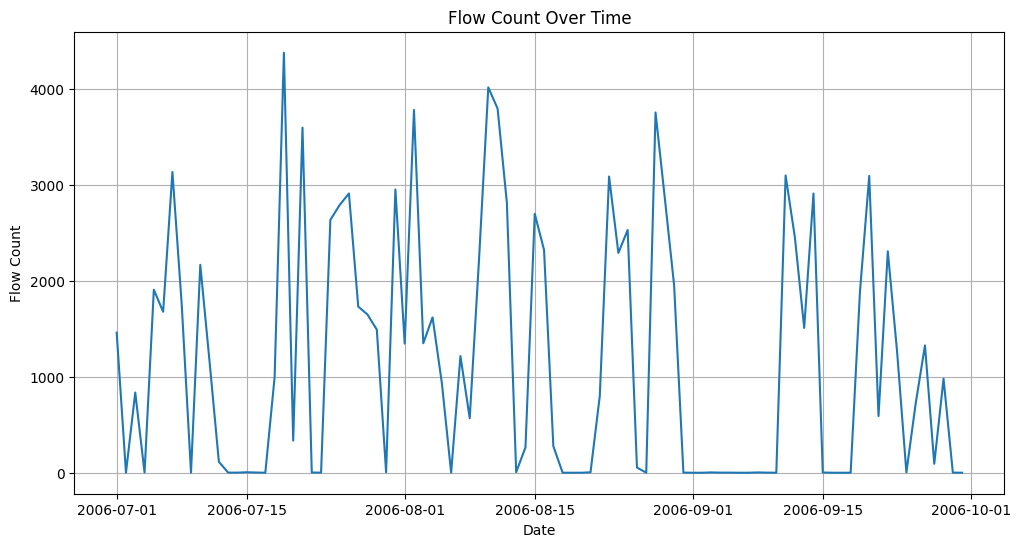

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['f'])
plt.title('Flow Count Over Time')
plt.xlabel('Date')
plt.ylabel('Flow Count')
plt.grid(True)
plt.show()

# Train-Test Split

**This cell splits the data into the data the model will train and the data the model will test. 75 percent of the data is used to train the model and the other 25 percent is used to test the model**

In [ ]:
train_size = int(len(df_2d) * 0.75)
test_size = len(df_2d) - train_size
train, test = df_2d[:train_size], df_2d[train_size:]

# Preprocessing
Data preprocessing is the first step in any data analysis or machine learning pipeline. It involves cleaning, transforming and organizing raw data to ensure it is accurate, consistent and ready for modeling.

**Robust Scaler**

* Robust Scaler is the normalization
method used since it does well with extreme values and outliers in datasets such as this one.

In [ ]:
robust_scaler = RobustScaler()
scaled_train = robust_scaler.fit_transform(train)
scaled_test = robust_scaler.transform(test)


**Create Dataset Function**
*  Stores the input sequences (features) and their corresponding target sequences,
*   The loop runs from the beginning of the dataset up to len(dataset) - look_back.  because for each input sequence of length look_back, you need a target sequence of the same length that follows it.

*   This structured format of input and target sequences is crucial for training sequence models like LSTMs, where the model learns to predict the next steps in a sequence based on the previous steps.


In [ ]:
def create_dataset(dataset, look_back):
    X , y = [], []
    for i in range(len(dataset)-look_back):
        feature = dataset[i:i+look_back]
        target = dataset[i+1:i+look_back+1]
        X.append(feature)
        y.append(target)
    return np.array(X), np.array(y)

Implementing the Create Dataset function

*  A lookback value of 5 means that each input sequence for the model will consist of 5 data points, and the model will try to predict the next data point
* We print the shape of the testing and training set to see what parameters are needed for the model


In [ ]:
look_back = 5
X_train, y_train = create_dataset(scaled_train, look_back=look_back)
X_test, y_test = create_dataset(scaled_test, look_back=look_back)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(64, 5, 1) (64, 5, 1)
(18, 5, 1) (18, 5, 1)


# Building and Training the LSTM Model
* Width variable is the number of time steps(look_back period) 5 and height is the number of features which is 1 (flows).
* Next we initialize the sequential model which is a stack of layers



**Layers of the model**


1.   The first later consists of an LSTM layer with 64 units wich are neurons for the model
* Return sequences is set to false meaninf the LSTM layer will output a single for each input sequence.
* Input_Shape specifies the shape of the input data
2.  The second layer is a Dropout layer with the rate of 0.3. A dropout layer helps prevent the model from training to well not allowing it to adjust to new data by setting a fraction of input units to 0.
3.  This adds a Dense (fully connected) layer with look_back units. This layer will output the predicted values.



**Compiling the Model**


*   Compiling the model tells the model how it will learn and how it's performance will be measured
*   The optimizer used is Adam with a learning rate of 0.01
* The metric used for loss which is the difference between the predicted and actual values is Mean Squared Error
* THe metric used used for accuracy is Mean Absolute Error
* The model.fit function trains the model. 100 epochs means it trains the model 100 times throught tthe training set and a batch size of 16 is the number of training samples processed in one forward and backward pass through the neural network before the model's parameters are updated


In [ ]:

width = np.shape(X_train)[1]
height = np.shape(y_train)[2]


LSTM_model = Sequential()
LSTM_model.add(LSTM(64, return_sequences=False, input_shape=(width, height)))
LSTM_model.add(Dropout(0.3))
LSTM_model.add(Dense(look_back))

optimizer = Adam(learning_rate=0.01)
LSTM_model.compile(loss=MeanSquaredError(), optimizer=optimizer, metrics=['mae'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = LSTM_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)


**Model Prediction**
* This obtains the predicted values of the trained model

In [ ]:
LSTM_y_pred = LSTM_model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


#Results
* Invert the Robust Scaling on the actual values and predicting vaules
* Mae:  the average of the absolute differences between predictions and actual values.
* R2 Score: the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A higher R2 score indicates a better fit of the model to the data.
* MAPE: It's a measure of the accuracy of a forecasting method. It expresses the accuracy as a percentage of the error relative to the actual value.

In [ ]:
unscaled_y_test = robust_scaler.inverse_transform(y_test.reshape(-1, look_back))
unscaled_LSTM_y_pred = robust_scaler.inverse_transform(LSTM_y_pred)
mae = mean_absolute_error(unscaled_y_test, unscaled_LSTM_y_pred)
r2 = r2_score(unscaled_y_test, unscaled_LSTM_y_pred)
mape = mean_absolute_percentage_error(unscaled_y_test, unscaled_LSTM_y_pred)
print(f"\nEvaluation Metrics for the Best Model:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")


Evaluation Metrics for the Best Model:
Mean Absolute Error (MAE): 331.8605
Root Mean Squared Error (RMSE): 578.2956
Mean Absolute Percentage Error (MAPE): 28.0161


## Visualizing Actuals vs Predictions
The graph below shows that the LSTM model predictions performed well with mirroring the shape of the actual values espescially around 83 time steps.


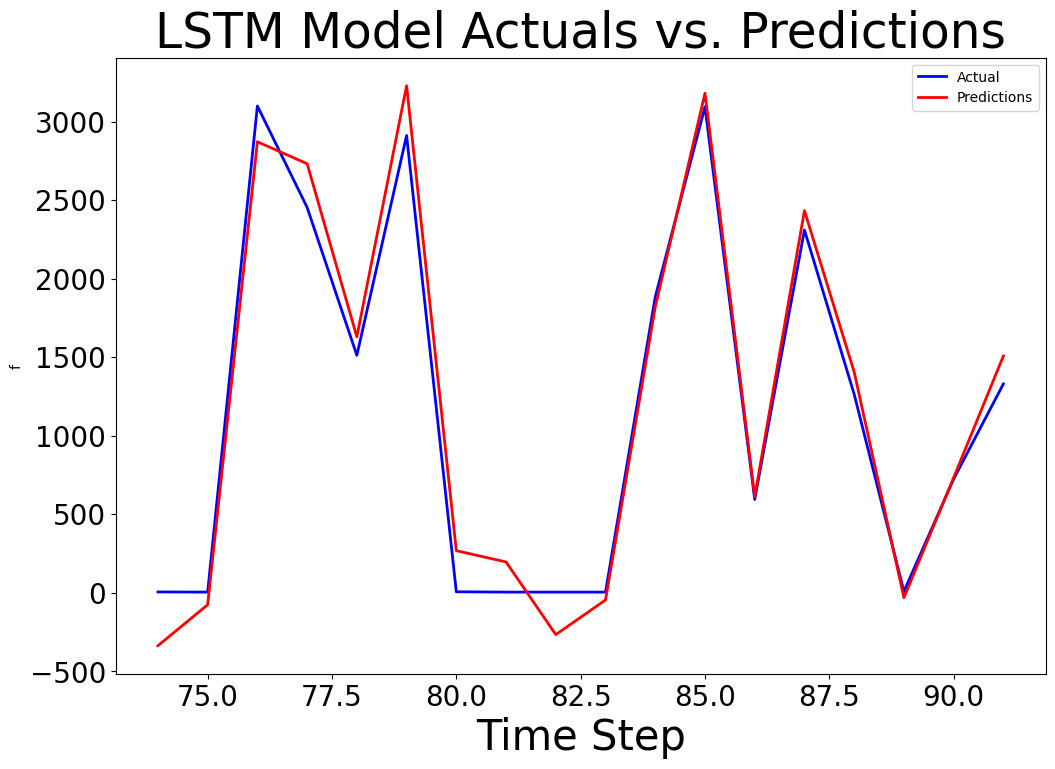

In [ ]:
# Plot actual vs. predicted values
plt.figure(figsize=(12, 8))
plt.title("LSTM Model Actuals vs. Predictions", fontsize=35)
plt.xlabel("Time Step", fontsize=30)
plt.ylabel("f")

test_indices = range(train_size + look_back, len(df_2d))
plt.plot(test_indices, unscaled_y_test[:, 0], c='b', lw=2, label='Actual')
plt.plot(test_indices, unscaled_LSTM_y_pred[:, 0], c='r', lw=2, label='Predictions')

plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()
plt.show()